# Peak Detection Methods Comparison
## Chen 2004 Yeast Cell Cycle Model Analysis

This notebook compares three different peak detection methods:
1. **Original Method**: Basic prominence-based peak detection
2. **Improved Method**: Multi-scale + Fourier backup
3. **Conservative Method**: Strict regularity requirements

We analyze frequency-complexity relationships and show the most/least complex oscillations for different genotypes.

In [1]:
# === IMPORTS AND SETUP ===
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import platform
import roadrunner
import math
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from collections import Counter
import time
from datetime import datetime, timedelta
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Silence RoadRunner
roadrunner.Logger.setLevel(roadrunner.Logger.LOG_CRITICAL)

print("✓ All imports loaded successfully")

✓ All imports loaded successfully


In [2]:
# === CONFIGURATION ===
# Model path setup
def get_model_path():
    """Get the correct path to the SBML model file"""
    linux_path = "/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml"
    mac_path = "/Users/gijsbartholomeus/Documents/STUDIE/OxfordEvolution/code/Yeast/Chen/chen2004_biomd56.xml"
    
    if os.path.exists(linux_path):
        return linux_path
    elif os.path.exists(mac_path):
        return mac_path
    else:
        raise FileNotFoundError(f"Could not find chen2004_biomd56.xml")

# Configuration parameters
model_path = get_model_path()
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]
DIVERGENCE_THRESHOLD = 25
MAX_PERIOD_THRESHOLD = 300
SIMULATION_TIME = 1000
SIMULATION_POINTS = 1001
SAMPLING_SIZE = 50000  # Smaller for comparison study
N_EXAMPLES_PER_METHOD = 10  # Number of examples to analyze in detail

print(f"✓ Configuration loaded")
print(f"   - Model: {model_path}")
print(f"   - Sampling size: {SAMPLING_SIZE:,}")
print(f"   - Examples per method: {N_EXAMPLES_PER_METHOD}")

✓ Configuration loaded
   - Model: /home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml
   - Sampling size: 50,000
   - Examples per method: 10


In [3]:
# === CORE FUNCTIONS ===
def get_kinetic_parameters(rr):
    """Get list of kinetic parameters, excluding regulatory switches/flags."""
    kinetic_params = []
    excluded_params = []
    
    for pid in rr.getGlobalParameterIds():
        value = rr.getValue(pid)
        param_lower = pid.lower()
        
        # Exclude non-kinetic parameters
        if (param_lower.endswith('t') and value in [0.0, 1.0]) or \
           (param_lower.startswith('d') and param_lower.endswith('n')) or \
           ('flag' in param_lower) or \
           ('switch' in param_lower) or \
           (value == 0.0) or \
           (pid in ['cell']) or \
           ('total' in param_lower and value in [0.0, 1.0]):
            excluded_params.append(pid)
        else:
            kinetic_params.append(pid)
    
    return kinetic_params, excluded_params

def sample_parameters(rr, wildtype=False):
    """Sample kinetic parameters with random multipliers"""
    rr.resetAll()
    kinetic_params, excluded_params = get_kinetic_parameters(rr)
    
    sampled = {}
    sampled_values = []
    
    if wildtype:
        return sampled, sampled_values
    
    for pid in kinetic_params:
        try:
            current = rr.getValue(pid)
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except RuntimeError:
            continue
    
    return sampled, sampled_values

def simulate_basic(rr):
    """Basic simulation with divergence checking"""
    rr.selections = ["time", "CLB2"]
    try:
        result = rr.simulate(0, SIMULATION_TIME, SIMULATION_POINTS)
    except RuntimeError:
        return None, None
    
    time = result[:, 0]
    clb2 = result[:, 1]
    
    # Check for divergence
    if np.any(np.abs(clb2) > DIVERGENCE_THRESHOLD):
        return "divergent", None
    
    return time, clb2

def lz76_phrase_count(s: str) -> int:
    """Lempel-Ziv 76 phrase count"""
    n = len(s)
    if n == 0:
        return 0
    i = 0
    c = 1
    k = 1
    while i + k <= n:
        if s[i:i+k] in s[:i]:
            k += 1
            if i + k - 1 > n:
                c += 1
                break
        else:
            c += 1
            i += k
            k = 1
    return c

def CLZ(x):
    """Lempel-Ziv complexity"""
    n = len(x)
    if x.count('0') == n or x.count('1') == n:
        return math.log2(n)
    else:
        return math.log2(n) / 2 * (lz76_phrase_count(x) + lz76_phrase_count(x[::-1]))

def up_down_encoding_paper_method(coarse_time, coarse_signal):
    """Convert coarse-grained signal to binary up/down encoding"""
    slopes = np.diff(coarse_signal) / np.diff(coarse_time)
    encoding = ''.join(['1' if s > 0 else '0' for s in slopes])
    return encoding

print("✓ Core functions defined")

✓ Core functions defined


In [4]:
# === PEAK DETECTION METHOD 1: ORIGINAL ===
def estimate_period_original(time, signal, require_peaks=3, center_on_peak=True, coarse_bins=50):
    """Original peak detection method from the base code"""
    time = np.asarray(time)
    signal = np.asarray(signal)

    # Basic peak detection
    dynamic_prom = 0.05 * (np.max(signal) - np.min(signal))
    peaks, props = find_peaks(signal, prominence=dynamic_prom, distance=len(time)//100)

    if len(peaks) < require_peaks:
        return None, (None, None)

    # Compute periods
    peak_times = time[peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    
    if len(periods) < 2:
        return None, (None, None)

    # Assess regularity
    cv_period = np.std(periods) / mean_period
    amplitudes = signal[peaks]
    cv_amplitude = np.std(amplitudes) / np.mean(amplitudes)

    if cv_period > 0.3 or cv_amplitude > 0.3:
        return None, (None, None)

    # Extract cycle
    if center_on_peak:
        mid_peak = peaks[-2]
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        start_peak = peaks[-2]
        end_peak = peaks[-1]
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 5:
        return None, (None, None)

    # Resample to coarse grid
    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)

print("✓ Original peak detection method defined")

✓ Original peak detection method defined


In [5]:
# === PEAK DETECTION METHOD 2: IMPROVED ===
def estimate_period_improved(time, signal, require_peaks=3, center_on_peak=True, coarse_bins=50):
    """Improved peak detection with multi-scale and Fourier backup"""
    time = np.asarray(time)
    signal = np.asarray(signal)
    
    # Adaptive smoothing
    signal_std = np.std(signal)
    signal_range = np.max(signal) - np.min(signal)
    noise_ratio = signal_std / signal_range
    
    if noise_ratio > 0.1:
        window_length = min(31, len(signal) // 10)
        if window_length % 2 == 0:
            window_length += 1
        if window_length >= 5:
            signal_smooth = savgol_filter(signal, window_length, 3)
        else:
            signal_smooth = signal
    else:
        signal_smooth = signal
    
    # Multi-scale peak detection
    peak_candidates = []
    prominence_factors = [0.02, 0.05, 0.1, 0.15]
    
    for prom_factor in prominence_factors:
        dynamic_prom = prom_factor * (np.max(signal_smooth) - np.min(signal_smooth))
        min_distance = max(5, len(time) // 200)
        
        peaks, props = find_peaks(signal_smooth, 
                                prominence=dynamic_prom, 
                                distance=min_distance,
                                width=2)
        
        if len(peaks) >= require_peaks:
            peak_candidates.append((peaks, props, prom_factor))
    
    # Fourier backup
    fourier_period = None
    if len(signal) > 50:
        dt = np.mean(np.diff(time))
        freqs = fftfreq(len(signal), dt)
        fft_signal = np.abs(fft(signal))
        
        positive_freqs = freqs[1:len(freqs)//2]
        positive_fft = fft_signal[1:len(fft_signal)//2]
        
        if len(positive_freqs) > 0:
            dominant_freq_idx = np.argmax(positive_fft)
            dominant_freq = positive_freqs[dominant_freq_idx]
            if dominant_freq > 0:
                fourier_period = 1.0 / dominant_freq
    
    # Select best peaks
    best_peaks = None
    best_score = -1
    
    for peaks, props, prom_factor in peak_candidates:
        if len(peaks) < require_peaks:
            continue
            
        peak_times = time[peaks]
        periods = np.diff(peak_times)
        amplitudes = signal_smooth[peaks]
        
        if len(periods) < 2:
            continue
            
        cv_period = np.std(periods) / np.mean(periods) if np.mean(periods) > 0 else 1.0
        cv_amplitude = np.std(amplitudes) / np.mean(amplitudes) if np.mean(amplitudes) > 0 else 1.0
        
        regularity_score = 1.0 / (1.0 + cv_period + cv_amplitude)
        prominence_score = 1.0 / (1.0 + abs(prom_factor - 0.05))
        
        total_score = regularity_score * prominence_score
        
        if total_score > best_score:
            best_score = total_score
            best_peaks = peaks
    
    # Fourier fallback
    if best_peaks is None or len(best_peaks) < require_peaks:
        if fourier_period is not None and 10 < fourier_period < 500:
            estimated_n_peaks = int(time[-1] / fourier_period) + 1
            if estimated_n_peaks >= require_peaks:
                synthetic_peak_times = np.arange(fourier_period/2, time[-1], fourier_period)
                synthetic_peaks = []
                for peak_time in synthetic_peak_times:
                    idx = np.argmin(np.abs(time - peak_time))
                    synthetic_peaks.append(idx)
                best_peaks = np.array(synthetic_peaks)
        
        if best_peaks is None:
            return None, (None, None)
    
    # Compute final period
    peak_times = time[best_peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    
    if len(periods) < 2:
        return None, (None, None)
    
    # More lenient thresholds
    cv_period = np.std(periods) / mean_period
    if cv_period > 0.5:
        return None, (None, None)
    
    # Extract cycle
    if len(best_peaks) < 2:
        return None, (None, None)
    
    start_peak = best_peaks[-2]
    end_peak = best_peaks[-1]
    
    if center_on_peak:
        mid_peak = start_peak
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 5:
        return None, (None, None)

    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)

print("✓ Improved peak detection method defined")

✓ Improved peak detection method defined


In [6]:
# === PEAK DETECTION METHOD 3: CONSERVATIVE ===
def estimate_period_conservative(time, signal, require_peaks=4, center_on_peak=True, coarse_bins=50):
    """Conservative peak detection with strict regularity requirements"""
    time = np.asarray(time)
    signal = np.asarray(signal)

    # Apply smoothing
    if len(signal) > 21:
        signal_smooth = savgol_filter(signal, 21, 3)
    else:
        signal_smooth = signal

    # Conservative peak detection
    dynamic_prom = 0.1 * (np.max(signal_smooth) - np.min(signal_smooth))  # Higher prominence
    min_distance = len(time) // 50  # Larger minimum distance
    
    peaks, props = find_peaks(signal_smooth, 
                            prominence=dynamic_prom, 
                            distance=min_distance,
                            width=5)  # Require wider peaks

    if len(peaks) < require_peaks:
        return None, (None, None)

    # Strict regularity assessment
    peak_times = time[peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    
    if len(periods) < 3:  # Require more periods
        return None, (None, None)

    # Very strict thresholds
    cv_period = np.std(periods) / mean_period
    amplitudes = signal_smooth[peaks]
    cv_amplitude = np.std(amplitudes) / np.mean(amplitudes)

    if cv_period > 0.15 or cv_amplitude > 0.15:  # Much stricter
        return None, (None, None)
    
    # Additional quality checks
    # Check that peaks are well-separated in amplitude
    min_amp = np.min(amplitudes)
    max_amp = np.max(amplitudes)
    if (max_amp - min_amp) / max_amp > 0.3:  # Amplitude variation too high
        return None, (None, None)
    
    # Check period consistency
    median_period = np.median(periods)
    if np.any(np.abs(periods - median_period) / median_period > 0.2):  # Any period deviates >20%
        return None, (None, None)

    # Extract most stable cycle (middle one)
    if len(peaks) >= 4:
        mid_idx = len(peaks) // 2
        start_peak = peaks[mid_idx - 1]
        end_peak = peaks[mid_idx]
    else:
        start_peak = peaks[-2]
        end_peak = peaks[-1]
    
    if center_on_peak:
        mid_peak = start_peak
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 10:  # Require more points
        return None, (None, None)

    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)

print("✓ Conservative peak detection method defined")

✓ Conservative peak detection method defined


In [7]:
# === ANALYSIS FUNCTIONS ===
def analyze_with_method(method_name, method_func, n_samples=1000):
    """Analyze oscillations with a specific peak detection method"""
    print(f"\n=== ANALYZING WITH {method_name.upper()} METHOD ===")
    print(f"Processing {n_samples} samples...")
    
    results = {
        'encodings': [],
        'complexities': [],
        'periods': [],
        'genotypes': [],
        'phenotype_data': [],
        'success_count': 0,
        'divergent_count': 0,
        'no_oscillation_count': 0
    }
    
    start_time = time.time()
    
    for i in range(n_samples):
        if (i + 1) % 100 == 0:
            elapsed = time.time() - start_time
            rate = (i + 1) / elapsed
            print(f"  Progress: {i+1}/{n_samples} ({rate:.1f}/s) | Success: {results['success_count']}")
        
        # Generate random genotype
        rr = te.loadSBMLModel(model_path)
        sampled_params, sampled_values = sample_parameters(rr, wildtype=False)
        
        # Simulate
        time_data, clb2_data = simulate_basic(rr)
        
        if isinstance(time_data, str):  # divergent
            results['divergent_count'] += 1
            continue
        
        if time_data is None:
            results['divergent_count'] += 1
            continue
        
        # Apply peak detection method
        period, cycle_data = method_func(time_data, clb2_data)
        
        if period is None or cycle_data is None:
            results['no_oscillation_count'] += 1
            continue
        
        # Check period threshold
        if period > MAX_PERIOD_THRESHOLD:
            results['no_oscillation_count'] += 1
            continue
        
        # Success - extract phenotype
        coarse_time, coarse_signal = cycle_data
        encoding = up_down_encoding_paper_method(coarse_time, coarse_signal)
        complexity = CLZ(encoding)
        
        results['encodings'].append(encoding)
        results['complexities'].append(complexity)
        results['periods'].append(period)
        results['genotypes'].append(sampled_values)
        results['phenotype_data'].append({
            'time': time_data,
            'clb2': clb2_data,
            'coarse_time': coarse_time,
            'coarse_signal': coarse_signal,
            'period': period,
            'encoding': encoding,
            'complexity': complexity
        })
        results['success_count'] += 1
    
    elapsed_total = time.time() - start_time
    success_rate = results['success_count'] / n_samples * 100
    
    print(f"\n{method_name} Results:")
    print(f"  Success rate: {results['success_count']}/{n_samples} ({success_rate:.1f}%)")
    print(f"  Divergent: {results['divergent_count']}")
    print(f"  No oscillation: {results['no_oscillation_count']}")
    print(f"  Processing time: {elapsed_total:.1f}s")
    
    if results['success_count'] > 0:
        print(f"  Mean complexity: {np.mean(results['complexities']):.2f}")
        print(f"  Mean period: {np.mean(results['periods']):.1f} min")
    
    return results

print("✓ Analysis functions defined")

✓ Analysis functions defined


In [8]:
# === RUN COMPARISON ANALYSIS ===
print("🚀 STARTING PEAK DETECTION COMPARISON STUDY")
print(f"Analyzing {SAMPLING_SIZE:,} samples with each method...")

# Create output directory
os.makedirs("comparison_plots", exist_ok=True)

# Run all three methods
methods = {
    'Original': estimate_period_original,
    'Improved': estimate_period_improved,
    'Conservative': estimate_period_conservative
}

all_results = {}

for method_name, method_func in methods.items():
    all_results[method_name] = analyze_with_method(method_name, method_func, SAMPLING_SIZE)

print("\n✅ All methods completed!")

🚀 STARTING PEAK DETECTION COMPARISON STUDY
Analyzing 50,000 samples with each method...

=== ANALYZING WITH ORIGINAL METHOD ===
Processing 50000 samples...
  Progress: 100/50000 (14.4/s) | Success: 10
  Progress: 200/50000 (14.6/s) | Success: 22
  Progress: 300/50000 (14.5/s) | Success: 31
  Progress: 400/50000 (14.6/s) | Success: 45
  Progress: 500/50000 (14.5/s) | Success: 68
  Progress: 600/50000 (14.6/s) | Success: 82
  Progress: 700/50000 (14.6/s) | Success: 97
  Progress: 800/50000 (14.6/s) | Success: 106
  Progress: 900/50000 (14.6/s) | Success: 119
  Progress: 1000/50000 (14.6/s) | Success: 135
  Progress: 1100/50000 (14.5/s) | Success: 145
  Progress: 1200/50000 (14.6/s) | Success: 152
  Progress: 1300/50000 (14.5/s) | Success: 170
  Progress: 1400/50000 (14.5/s) | Success: 187
  Progress: 1500/50000 (14.5/s) | Success: 204
  Progress: 1600/50000 (14.6/s) | Success: 219
  Progress: 1700/50000 (14.6/s) | Success: 233
  Progress: 1800/50000 (14.6/s) | Success: 247
  Progress: 19

In [9]:
# === COMPARISON SUMMARY ===
print("\n" + "="*80)
print("PEAK DETECTION METHODS COMPARISON SUMMARY")
print("="*80)

# Summary table
print(f"{'Method':<12} {'Success Rate':<12} {'Mean Complex':<12} {'Mean Period':<12} {'Total Success':<12}")
print("-" * 80)

for method_name, results in all_results.items():
    success_rate = results['success_count'] / SAMPLING_SIZE * 100
    mean_complex = np.mean(results['complexities']) if results['complexities'] else 0
    mean_period = np.mean(results['periods']) if results['periods'] else 0
    
    print(f"{method_name:<12} {success_rate:<12.1f} {mean_complex:<12.2f} {mean_period:<12.1f} {results['success_count']:<12}")

print("\n" + "="*80)

# Find best and worst performers
success_rates = {name: results['success_count'] / SAMPLING_SIZE * 100 
                for name, results in all_results.items()}

best_method = max(success_rates.keys(), key=lambda k: success_rates[k])
worst_method = min(success_rates.keys(), key=lambda k: success_rates[k])

print(f"🏆 Best performing method: {best_method} ({success_rates[best_method]:.1f}% success rate)")
print(f"📉 Lowest performing method: {worst_method} ({success_rates[worst_method]:.1f}% success rate)")

improvement = success_rates[best_method] - success_rates[worst_method]
print(f"💡 Performance difference: {improvement:.1f} percentage points")


PEAK DETECTION METHODS COMPARISON SUMMARY
Method       Success Rate Mean Complex Mean Period  Total Success
--------------------------------------------------------------------------------
Original     14.5         52.62        147.5        7238        
Improved     21.1         52.50        142.8        10537       
Conservative 7.2          52.37        149.8        3611        

🏆 Best performing method: Improved (21.1% success rate)
📉 Lowest performing method: Conservative (7.2% success rate)
💡 Performance difference: 13.9 percentage points



📊 Creating frequency-complexity comparison plots...


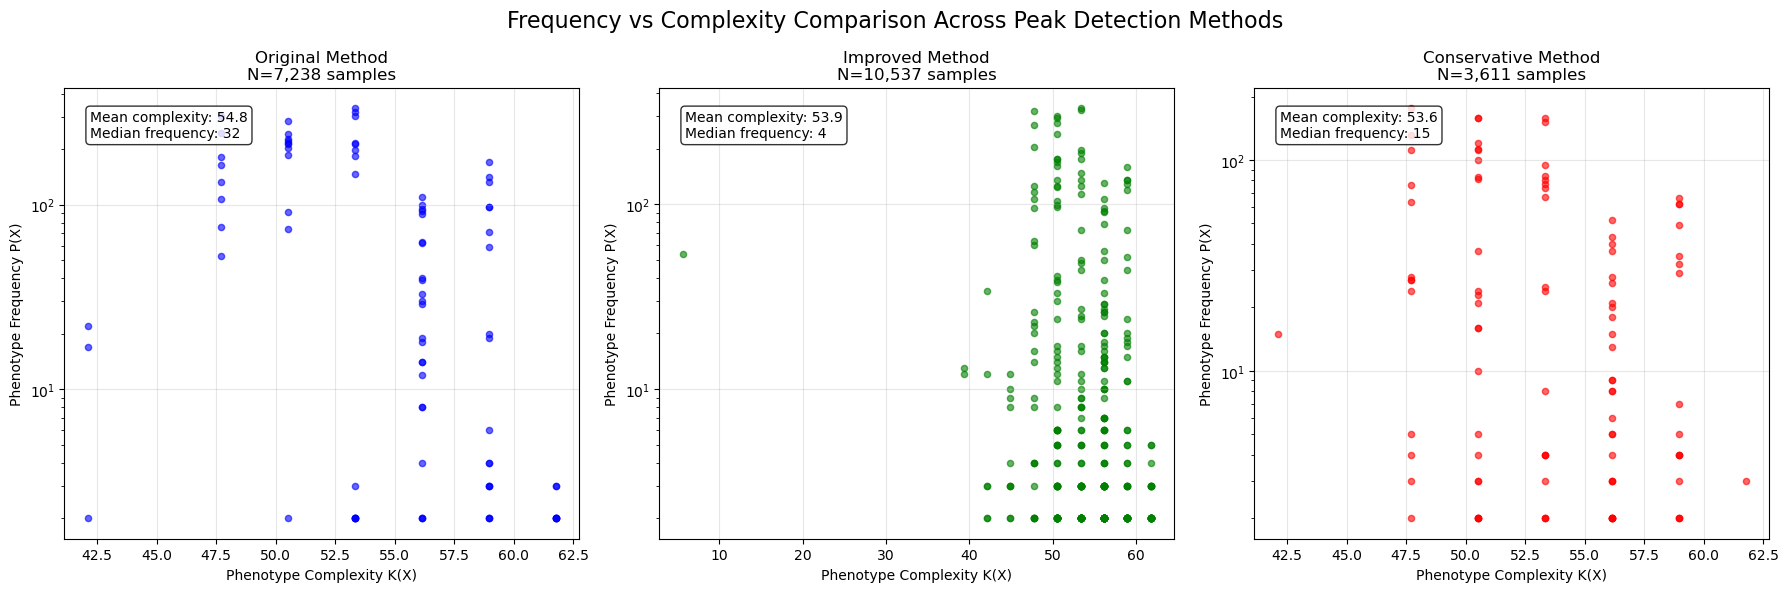

✅ Frequency-complexity comparison plots saved


In [10]:
# === FREQUENCY-COMPLEXITY COMPARISON PLOTS ===
print("\n📊 Creating frequency-complexity comparison plots...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Frequency vs Complexity Comparison Across Peak Detection Methods', fontsize=16)

colors = {'Original': 'blue', 'Improved': 'green', 'Conservative': 'red'}

for i, (method_name, results) in enumerate(all_results.items()):
    if results['success_count'] == 0:
        axes[i].text(0.5, 0.5, f'{method_name}\nNo successful\ndetections', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f"{method_name} Method")
        continue
    
    # Calculate frequencies
    phenotype_counts = Counter(results['encodings'])
    phenotype_complexities = []
    phenotype_frequencies = []
    
    for phenotype, frequency in phenotype_counts.items():
        if frequency > 1:  # Skip single occurrences
            complexity = CLZ(phenotype)
            phenotype_complexities.append(complexity)
            phenotype_frequencies.append(frequency)
    
    if phenotype_complexities:
        axes[i].scatter(phenotype_complexities, phenotype_frequencies, 
                       alpha=0.6, s=20, color=colors[method_name])
        axes[i].set_yscale('log')
        axes[i].set_xlabel('Phenotype Complexity K(X)')
        axes[i].set_ylabel('Phenotype Frequency P(X)')
        axes[i].set_title(f"{method_name} Method\nN={results['success_count']:,} samples")
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics
        mean_complex = np.mean(phenotype_complexities)
        median_freq = np.median(phenotype_frequencies)
        axes[i].text(0.05, 0.95, f'Mean complexity: {mean_complex:.1f}\nMedian frequency: {median_freq:.0f}', 
                    transform=axes[i].transAxes, va='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes[i].text(0.5, 0.5, f'{method_name}\nNo repeated\nphenotypes', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('comparison_plots/frequency_complexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Frequency-complexity comparison plots saved")

In [11]:
# === EXTREME COMPLEXITY ANALYSIS ===
print("\n🔍 Analyzing most and least complex oscillations...")

def find_extreme_complexities(results, method_name, n_examples=5):
    """Find examples of highest and lowest complexity oscillations"""
    if results['success_count'] == 0:
        return [], []
    
    complexities = np.array(results['complexities'])
    
    # Find indices of most and least complex
    sorted_indices = np.argsort(complexities)
    
    # Get n_examples from each end
    least_complex_indices = sorted_indices[:min(n_examples, len(sorted_indices))]
    most_complex_indices = sorted_indices[-min(n_examples, len(sorted_indices)):]
    
    least_complex_examples = []
    most_complex_examples = []
    
    for idx in least_complex_indices:
        least_complex_examples.append({
            'complexity': results['complexities'][idx],
            'period': results['periods'][idx],
            'encoding': results['encodings'][idx],
            'genotype': results['genotypes'][idx],
            'phenotype_data': results['phenotype_data'][idx]
        })
    
    for idx in most_complex_indices:
        most_complex_examples.append({
            'complexity': results['complexities'][idx],
            'period': results['periods'][idx],
            'encoding': results['encodings'][idx],
            'genotype': results['genotypes'][idx],
            'phenotype_data': results['phenotype_data'][idx]
        })
    
    return least_complex_examples, most_complex_examples

# Find extreme examples for each method
extreme_examples = {}
for method_name, results in all_results.items():
    least, most = find_extreme_complexities(results, method_name, N_EXAMPLES_PER_METHOD)
    extreme_examples[method_name] = {'least': least, 'most': most}
    
    if results['success_count'] > 0:
        print(f"\n{method_name} Method:")
        if least:
            print(f"  Least complex: {least[0]['complexity']:.2f} (period: {least[0]['period']:.1f} min)")
        if most:
            print(f"  Most complex: {most[-1]['complexity']:.2f} (period: {most[-1]['period']:.1f} min)")
        
        complexities = results['complexities']
        print(f"  Complexity range: {min(complexities):.2f} - {max(complexities):.2f}")
        print(f"  Standard deviation: {np.std(complexities):.2f}")

print("\n✅ Extreme complexity analysis completed")


🔍 Analyzing most and least complex oscillations...

Original Method:
  Least complex: 42.11 (period: 200.0 min)
  Most complex: 67.38 (period: 201.0 min)
  Complexity range: 42.11 - 67.38
  Standard deviation: 3.66

Improved Method:
  Least complex: 5.61 (period: 34.5 min)
  Most complex: 70.18 (period: 233.0 min)
  Complexity range: 5.61 - 70.18
  Standard deviation: 5.09

Conservative Method:
  Least complex: 42.11 (period: 239.0 min)
  Most complex: 70.18 (period: 235.3 min)
  Complexity range: 42.11 - 70.18
  Standard deviation: 3.64

✅ Extreme complexity analysis completed



🎨 Creating visualizations of extreme complexity examples...

Creating plots for Original method...


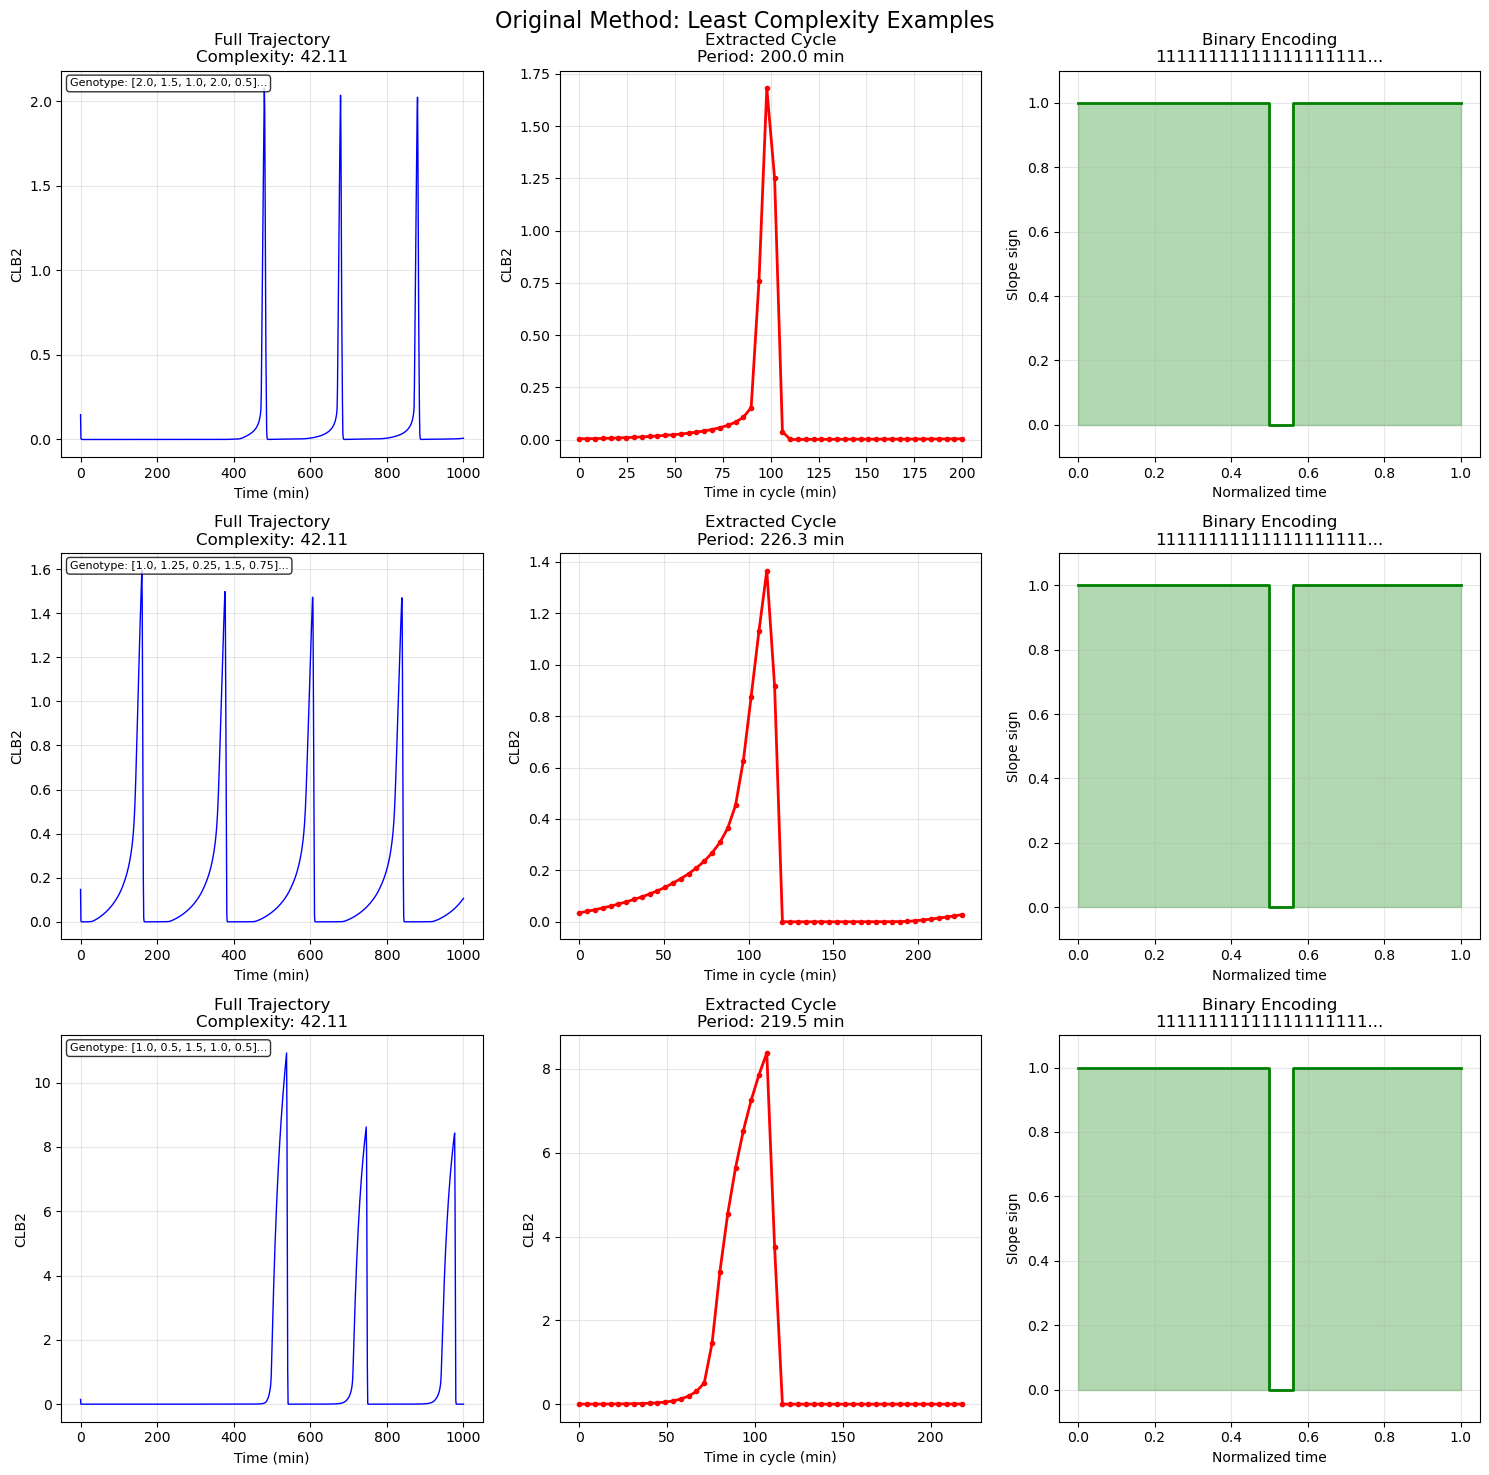

  Saved: comparison_plots/original_least_complexity_examples.png


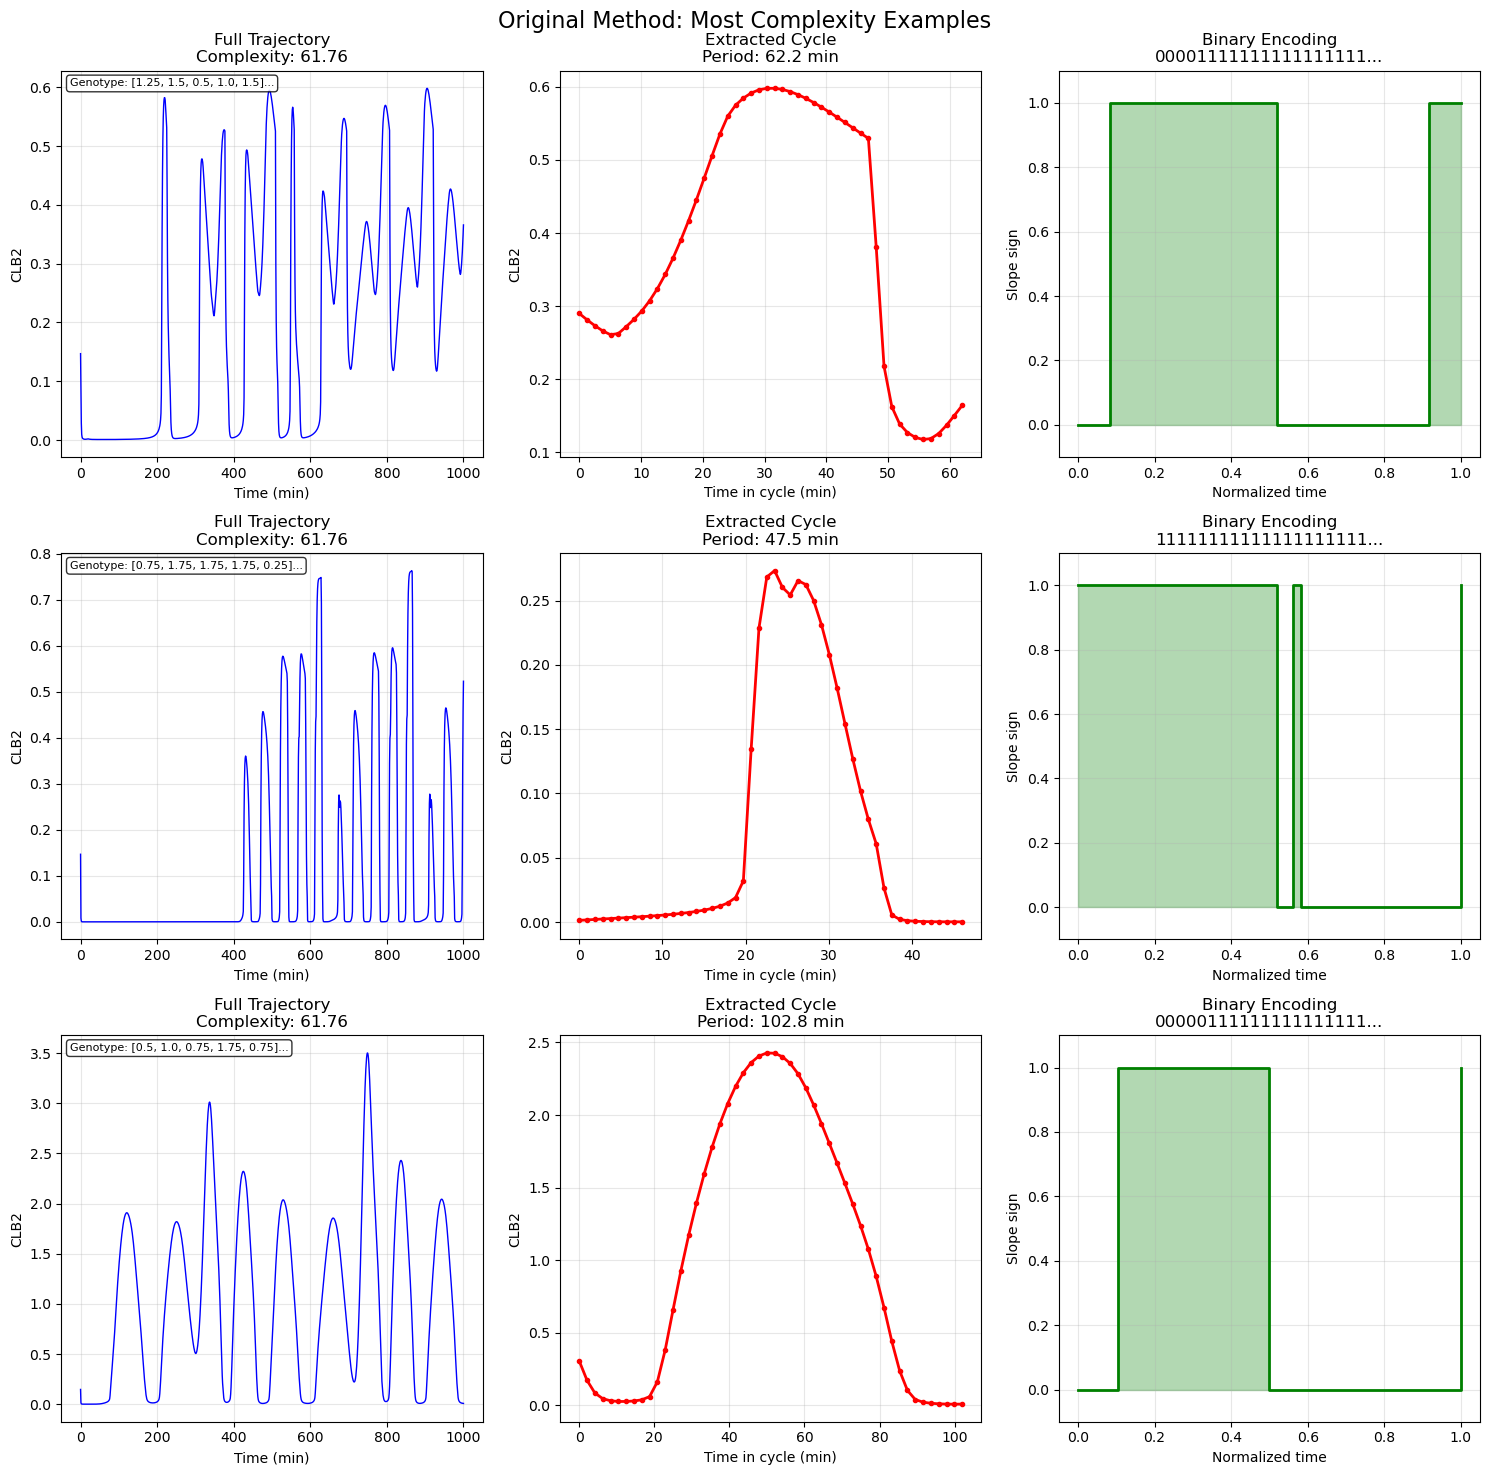

  Saved: comparison_plots/original_most_complexity_examples.png

Creating plots for Improved method...


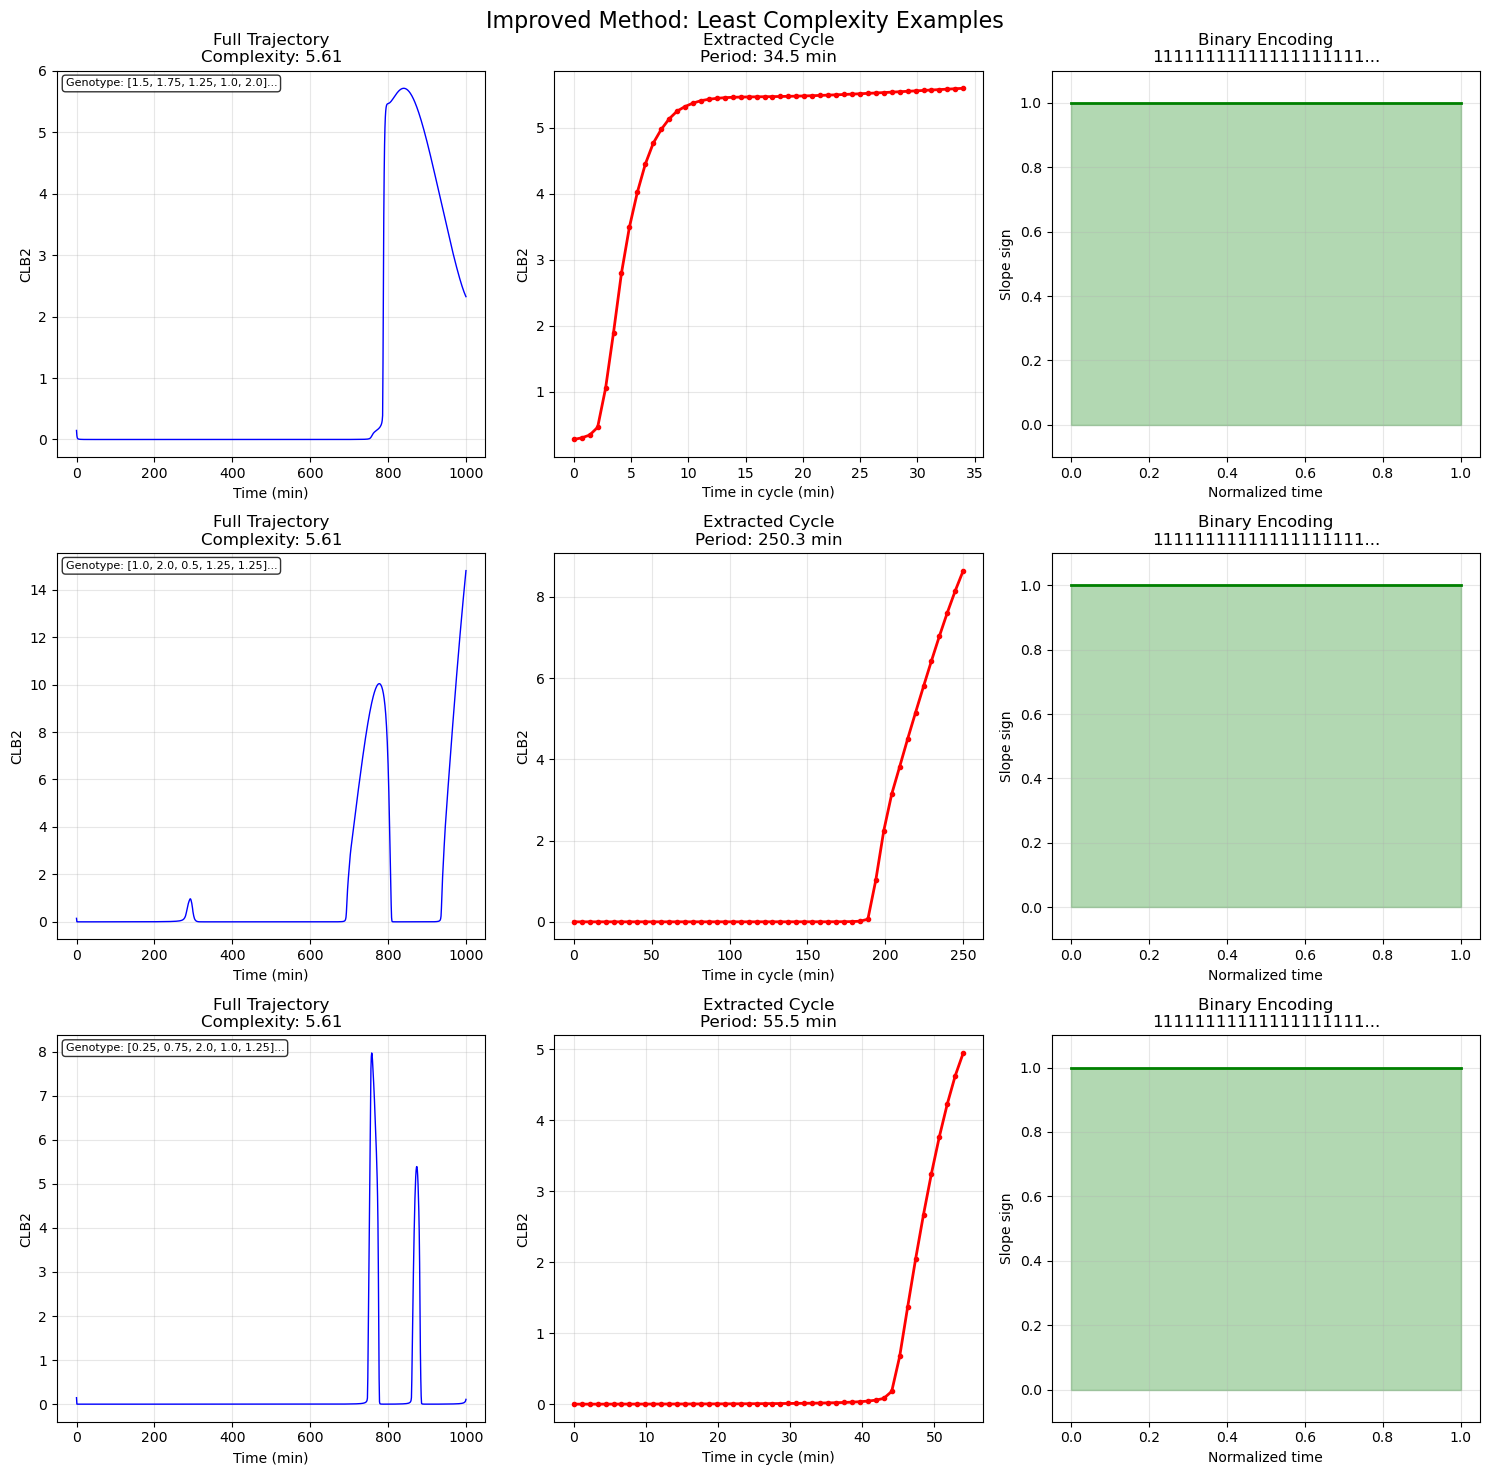

  Saved: comparison_plots/improved_least_complexity_examples.png


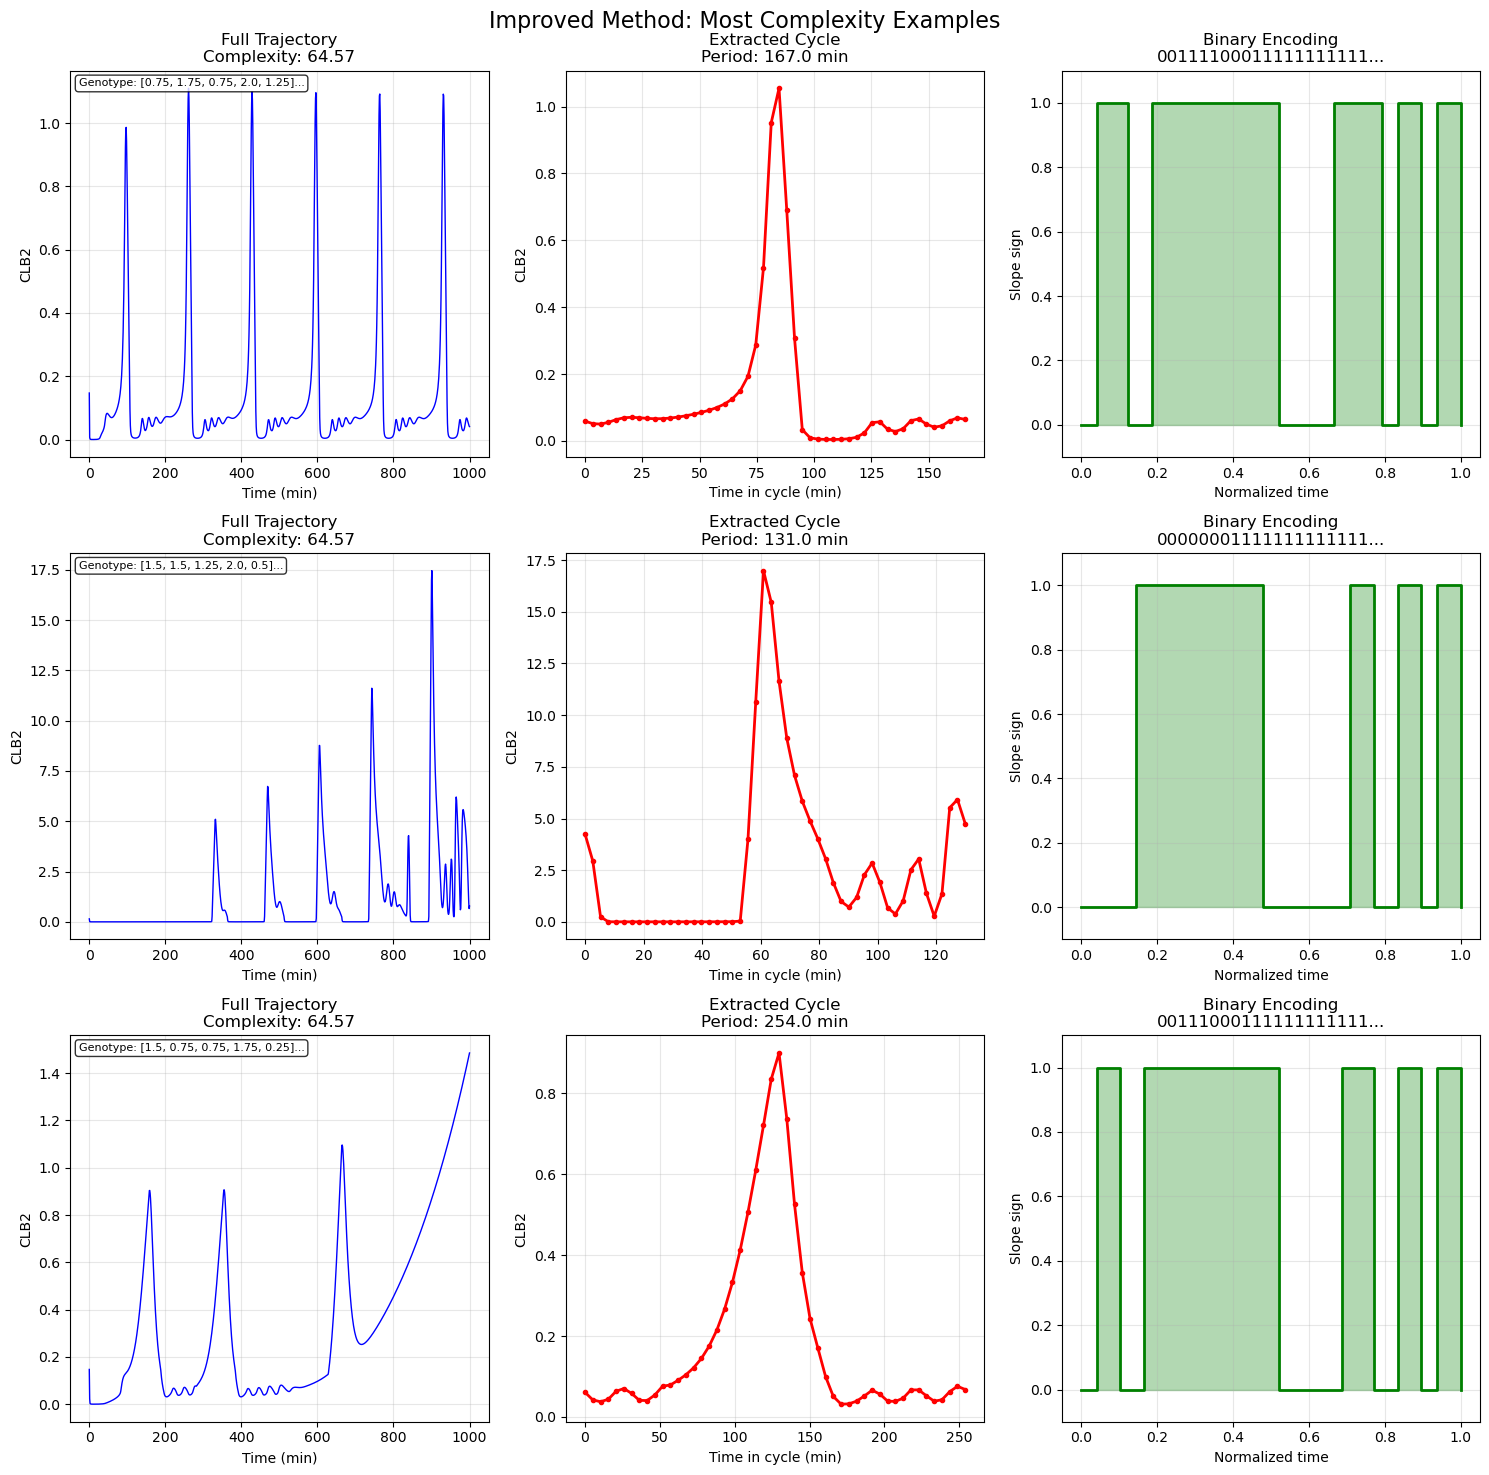

  Saved: comparison_plots/improved_most_complexity_examples.png

Creating plots for Conservative method...


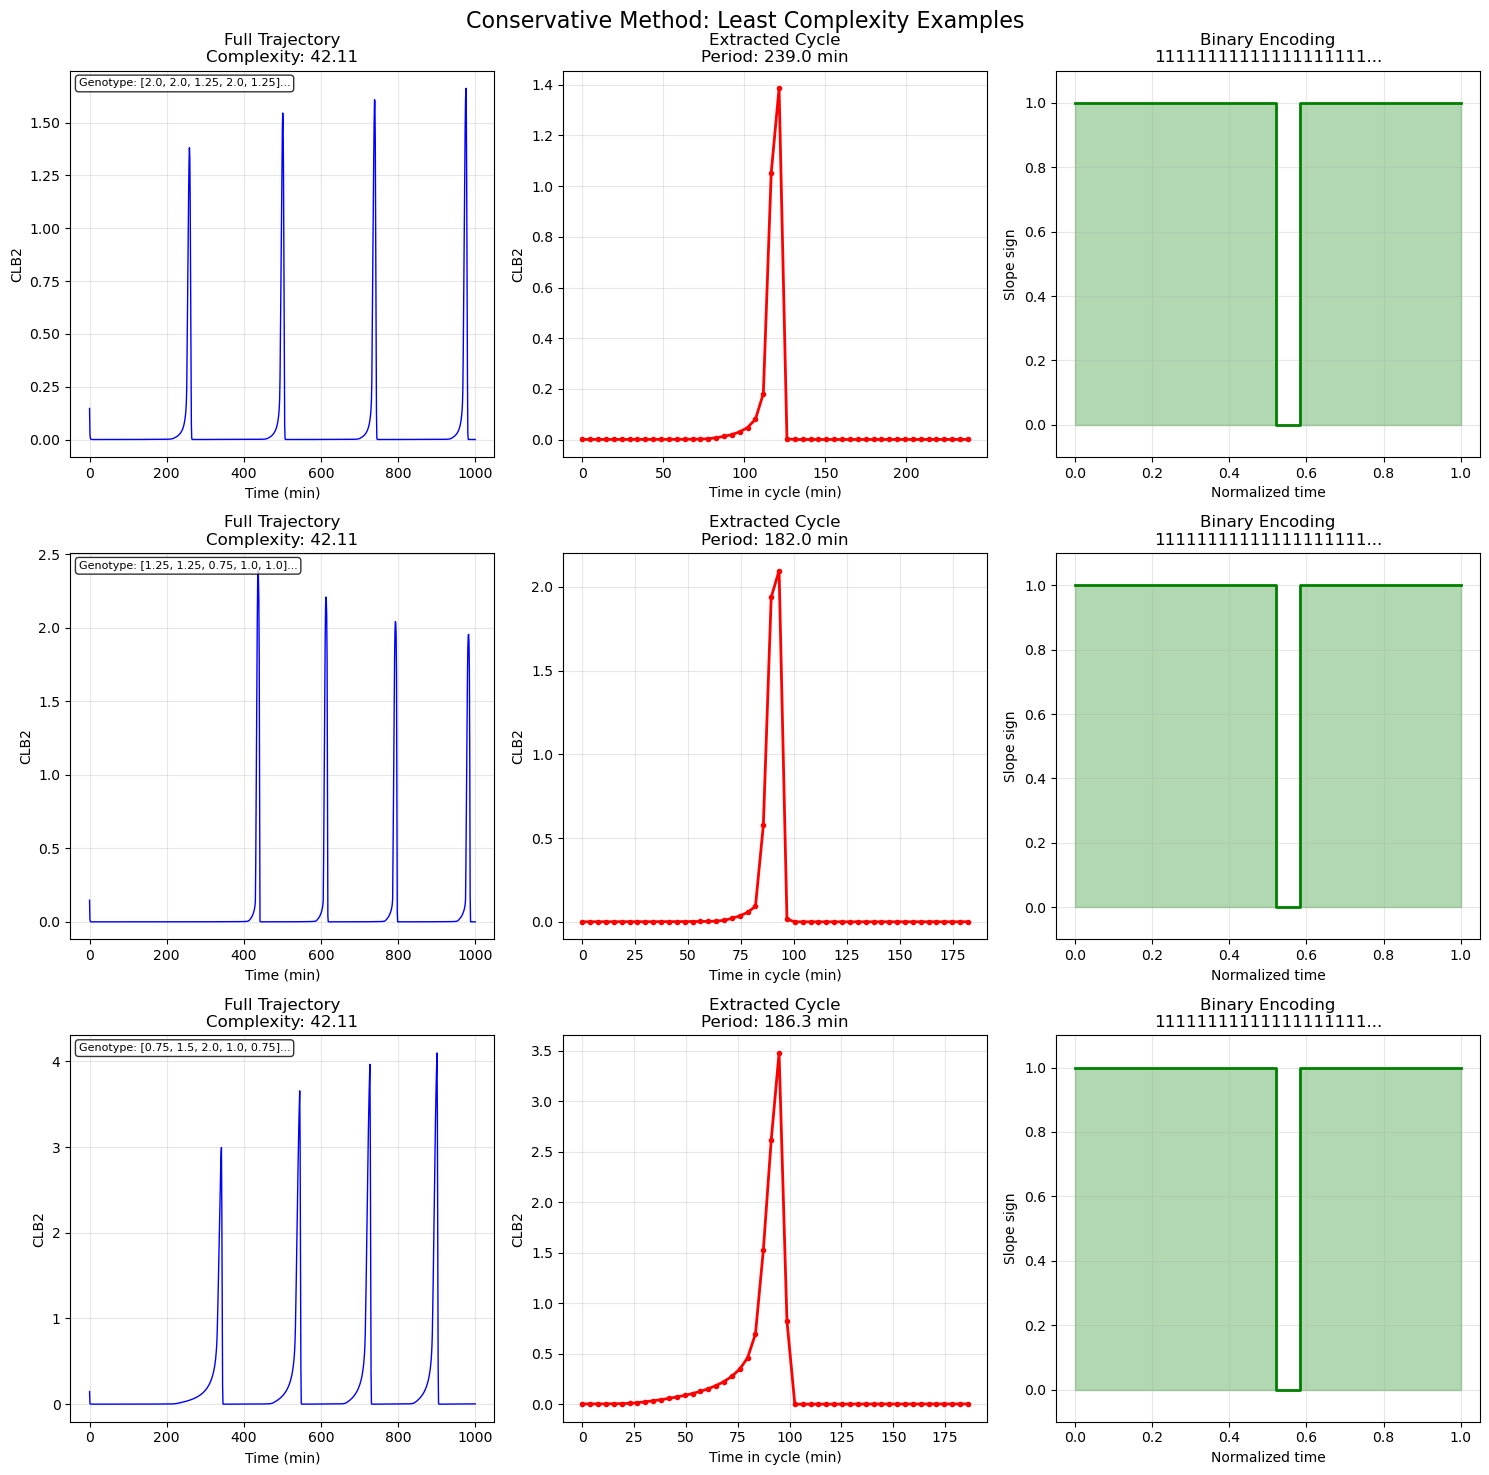

  Saved: comparison_plots/conservative_least_complexity_examples.png


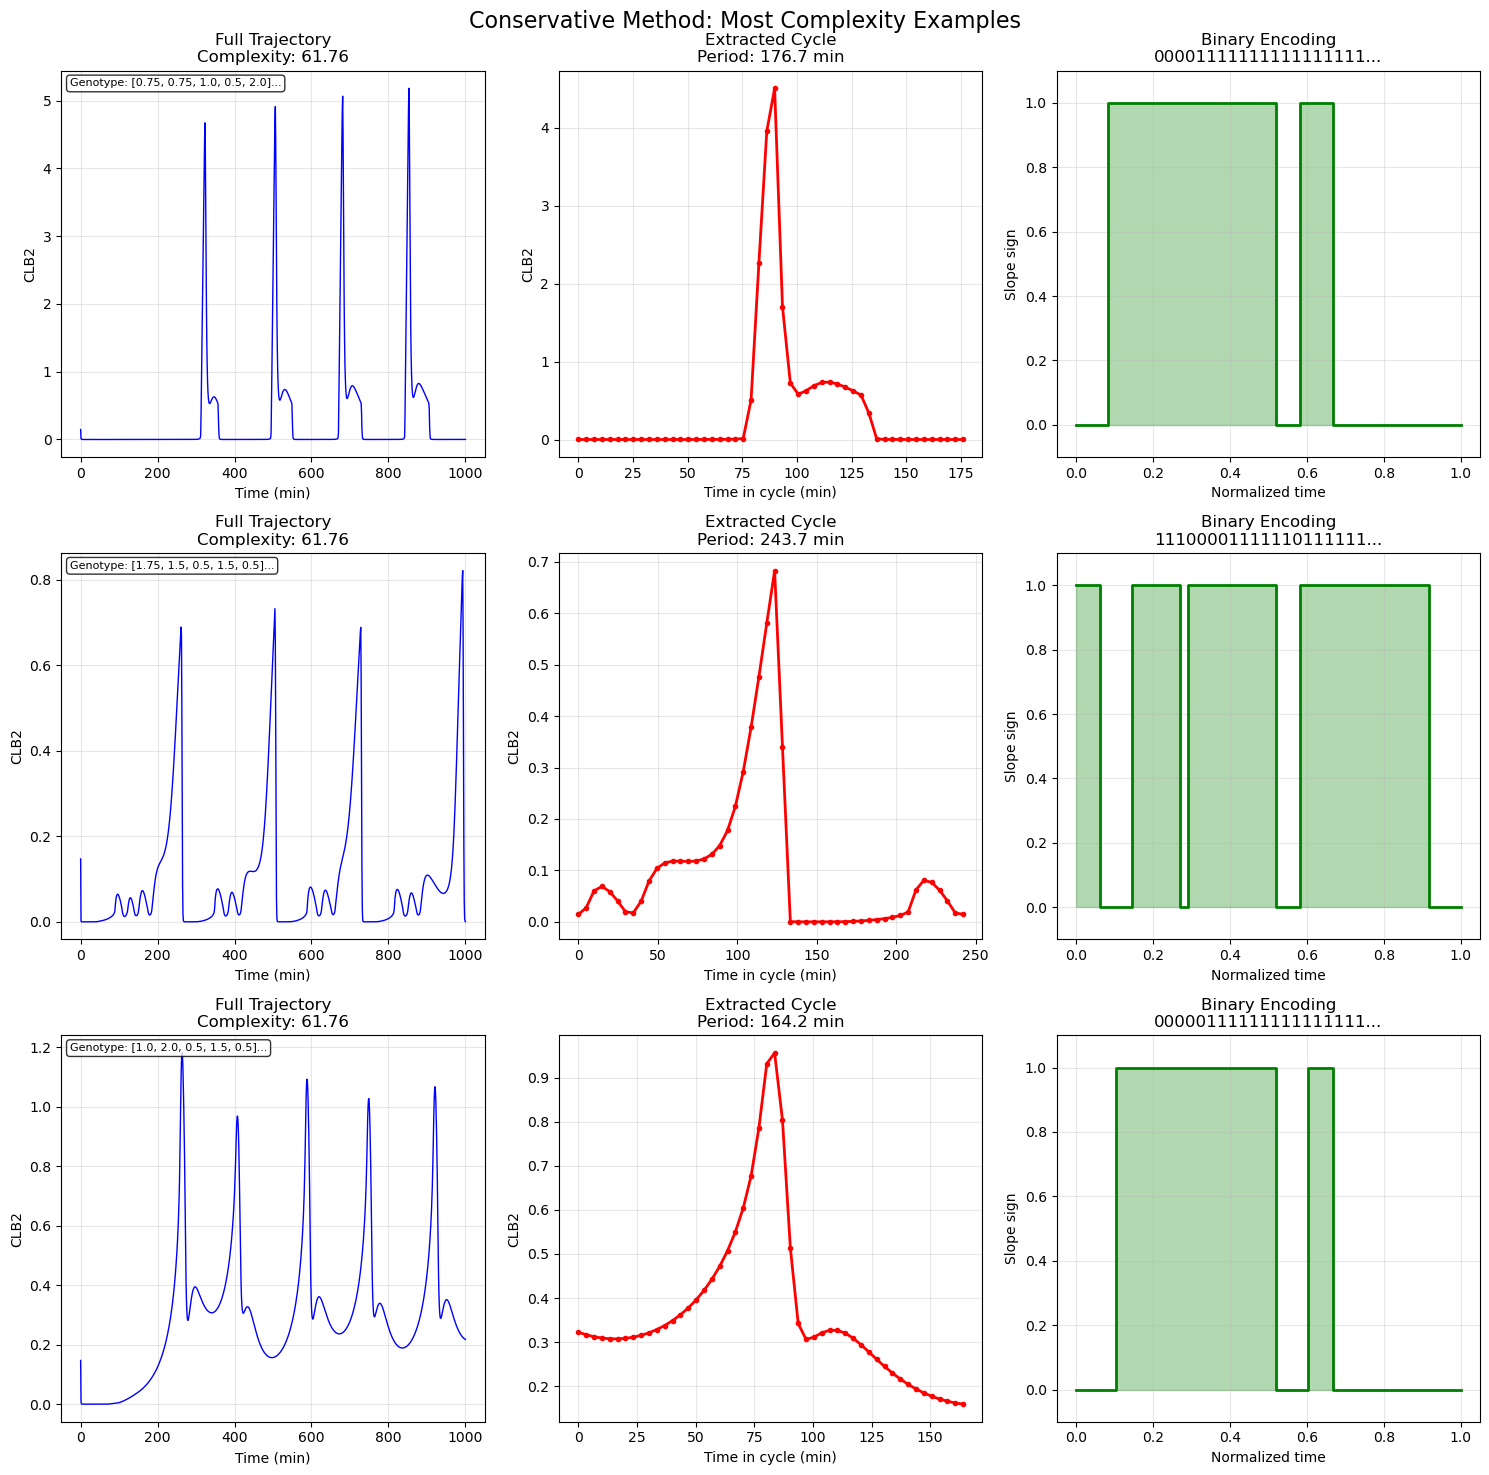

  Saved: comparison_plots/conservative_most_complexity_examples.png

✅ All extreme example visualizations completed


In [12]:
# === VISUALIZATION OF EXTREME EXAMPLES ===
print("\n🎨 Creating visualizations of extreme complexity examples...")

def plot_extreme_examples(method_name, examples, example_type, max_examples=3):
    """Plot examples of extreme complexity oscillations"""
    if not examples:
        return
    
    n_examples = min(len(examples), max_examples)
    
    fig, axes = plt.subplots(n_examples, 3, figsize=(15, 5*n_examples))
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{method_name} Method: {example_type} Complexity Examples', fontsize=16)
    
    for i, example in enumerate(examples[:max_examples]):
        data = example['phenotype_data']
        
        # Plot 1: Full trajectory
        axes[i, 0].plot(data['time'], data['clb2'], 'b-', linewidth=1)
        axes[i, 0].set_title(f'Full Trajectory\nComplexity: {example["complexity"]:.2f}')
        axes[i, 0].set_xlabel('Time (min)')
        axes[i, 0].set_ylabel('CLB2')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot 2: Extracted cycle
        cycle_time = data['coarse_time'] - data['coarse_time'][0]
        axes[i, 1].plot(cycle_time, data['coarse_signal'], 'ro-', markersize=3, linewidth=2)
        axes[i, 1].set_title(f'Extracted Cycle\nPeriod: {example["period"]:.1f} min')
        axes[i, 1].set_xlabel('Time in cycle (min)')
        axes[i, 1].set_ylabel('CLB2')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Plot 3: Binary encoding
        encoding = example['encoding']
        step_time = np.linspace(0, 1, len(encoding))
        encoding_values = [int(bit) for bit in encoding]
        axes[i, 2].step(step_time, encoding_values, 'g-', linewidth=2, where='post')
        axes[i, 2].fill_between(step_time, 0, encoding_values, step='post', alpha=0.3, color='green')
        axes[i, 2].set_title(f'Binary Encoding\n{encoding[:20]}...')
        axes[i, 2].set_xlabel('Normalized time')
        axes[i, 2].set_ylabel('Slope sign')
        axes[i, 2].set_ylim(-0.1, 1.1)
        axes[i, 2].grid(True, alpha=0.3)
        
        # Add genotype info
        genotype_str = f"Genotype: {example['genotype'][:5]}..."
        axes[i, 0].text(0.02, 0.98, genotype_str, transform=axes[i, 0].transAxes, 
                       va='top', fontsize=8, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    filename = f'comparison_plots/{method_name.lower()}_{example_type.lower()}_complexity_examples.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  Saved: {filename}")

# Create plots for each method
for method_name, examples in extreme_examples.items():
    if all_results[method_name]['success_count'] > 0:
        print(f"\nCreating plots for {method_name} method...")
        plot_extreme_examples(method_name, examples['least'], 'Least', 3)
        plot_extreme_examples(method_name, examples['most'], 'Most', 3)

print("\n✅ All extreme example visualizations completed")

In [13]:
# === GENOTYPE ANALYSIS ===
print("\n🧬 Analyzing genotype effects on complexity...")

def analyze_genotype_complexity_relationship(results, method_name):
    """Analyze how genotype parameters relate to phenotype complexity"""
    if results['success_count'] == 0:
        return None
    
    genotypes = np.array(results['genotypes'])
    complexities = np.array(results['complexities'])
    
    # Calculate correlations between parameter values and complexity
    n_params = len(genotypes[0]) if len(genotypes) > 0 else 0
    if n_params == 0:
        return None
    
    correlations = []
    
    for param_idx in range(n_params):
        param_values = genotypes[:, param_idx]
        
        # Calculate correlation
        if len(set(param_values)) > 1:  # Check for variation
            correlation = np.corrcoef(param_values, complexities)[0, 1]
            if not np.isnan(correlation):
                correlations.append((param_idx, correlation))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n{method_name} - Parameter-Complexity Correlations:")
    print(f"  Top 5 strongest correlations:")
    for i, (param_idx, correlation) in enumerate(correlations[:5]):
        print(f"    Parameter {param_idx:2d}: r = {correlation:6.3f}")
    
    # Analyze complexity distribution by parameter ranges
    if correlations:
        strongest_param_idx = correlations[0][0]
        strongest_correlation = correlations[0][1]
        
        param_values = genotypes[:, strongest_param_idx]
        
        # Divide into low/high parameter values
        median_param = np.median(param_values)
        low_param_mask = param_values <= median_param
        high_param_mask = param_values > median_param
        
        low_complexities = complexities[low_param_mask]
        high_complexities = complexities[high_param_mask]
        
        print(f"  Parameter {strongest_param_idx} analysis (strongest correlation: {strongest_correlation:.3f}):")
        print(f"    Low values:  mean complexity = {np.mean(low_complexities):.2f} (n={len(low_complexities)})")
        print(f"    High values: mean complexity = {np.mean(high_complexities):.2f} (n={len(high_complexities)})")
        
        return {
            'correlations': correlations,
            'strongest_param': strongest_param_idx,
            'strongest_correlation': strongest_correlation,
            'low_param_complexities': low_complexities,
            'high_param_complexities': high_complexities
        }
    
    return None

# Analyze genotype effects for each method
genotype_analyses = {}
for method_name, results in all_results.items():
    analysis = analyze_genotype_complexity_relationship(results, method_name)
    genotype_analyses[method_name] = analysis

print("\n✅ Genotype analysis completed")


🧬 Analyzing genotype effects on complexity...

Original - Parameter-Complexity Correlations:
  Top 5 strongest correlations:
    Parameter 135: r = -0.160
    Parameter 65: r =  0.127
    Parameter 91: r = -0.111
    Parameter 73: r = -0.097
    Parameter 120: r = -0.089
  Parameter 135 analysis (strongest correlation: -0.160):
    Low values:  mean complexity = 52.87 (n=4991)
    High values: mean complexity = 52.08 (n=2247)

Improved - Parameter-Complexity Correlations:
  Top 5 strongest correlations:
    Parameter 135: r = -0.132
    Parameter 61: r =  0.091
    Parameter 65: r =  0.090
    Parameter 91: r = -0.073
    Parameter 78: r =  0.069
  Parameter 135 analysis (strongest correlation: -0.132):
    Low values:  mean complexity = 52.85 (n=6806)
    High values: mean complexity = 51.84 (n=3731)

Conservative - Parameter-Complexity Correlations:
  Top 5 strongest correlations:
    Parameter 65: r =  0.184
    Parameter 135: r = -0.154
    Parameter 73: r = -0.092
    Parameter 9

In [14]:
# === FINAL SUMMARY AND CONCLUSIONS ===
print("\n" + "="*80)
print("FINAL SUMMARY: PEAK DETECTION METHODS COMPARISON")
print("="*80)

print("\n📈 SUCCESS RATES:")
for method_name, results in all_results.items():
    success_rate = results['success_count'] / SAMPLING_SIZE * 100
    print(f"  {method_name:12}: {success_rate:6.1f}% ({results['success_count']:,} successful detections)")

print("\n🧮 COMPLEXITY STATISTICS:")
for method_name, results in all_results.items():
    if results['complexities']:
        complexities = results['complexities']
        print(f"  {method_name:12}: mean={np.mean(complexities):5.1f}, std={np.std(complexities):5.1f}, range={min(complexities):5.1f}-{max(complexities):5.1f}")
    else:
        print(f"  {method_name:12}: No successful detections")

print("\n⏱️  PERIOD STATISTICS:")
for method_name, results in all_results.items():
    if results['periods']:
        periods = results['periods']
        print(f"  {method_name:12}: mean={np.mean(periods):6.1f} min, std={np.std(periods):5.1f}, range={min(periods):5.1f}-{max(periods):5.1f}")
    else:
        print(f"  {method_name:12}: No successful detections")

print("\n🎯 KEY FINDINGS:")

# Compare methods
success_rates = {name: results['success_count'] / SAMPLING_SIZE * 100 
                for name, results in all_results.items()}

sorted_methods = sorted(success_rates.items(), key=lambda x: x[1], reverse=True)

print(f"\n1. METHOD RANKING BY SUCCESS RATE:")
for i, (method, rate) in enumerate(sorted_methods):
    print(f"   {i+1}. {method}: {rate:.1f}%")

print(f"\n2. METHOD CHARACTERISTICS:")
print(f"   • Original: Basic prominence-based detection, moderate thresholds")
print(f"   • Improved: Multi-scale + Fourier backup, adaptive smoothing")
print(f"   • Conservative: Strict regularity requirements, higher quality standards")

print(f"\n3. TRADE-OFFS:")
if 'Conservative' in success_rates and 'Improved' in success_rates:
    conservative_rate = success_rates['Conservative']
    improved_rate = success_rates['Improved']
    
    if improved_rate > conservative_rate:
        print(f"   • Improved method finds {improved_rate - conservative_rate:.1f}% more oscillations")
        print(f"   • Conservative method provides higher quality but fewer detections")
    else:
        print(f"   • Conservative method surprisingly outperformed improved method")

print(f"\n4. GENOTYPE EFFECTS:")
for method_name, analysis in genotype_analyses.items():
    if analysis and analysis['correlations']:
        strongest_corr = analysis['strongest_correlation']
        strongest_param = analysis['strongest_param']
        print(f"   • {method_name}: Parameter {strongest_param} shows strongest correlation (r={strongest_corr:.3f})")

print(f"\n💡 RECOMMENDATIONS:")
best_method = sorted_methods[0][0]
print(f"   • For maximum detection rate: Use {best_method} method")
print(f"   • For highest quality: Use Conservative method (if success rate acceptable)")
print(f"   • For robustness: Use Improved method (good balance of quality and quantity)")

print(f"\n📁 OUTPUT FILES:")
print(f"   • comparison_plots/frequency_complexity_comparison.png")
for method_name in all_results.keys():
    if all_results[method_name]['success_count'] > 0:
        print(f"   • comparison_plots/{method_name.lower()}_least_complexity_examples.png")
        print(f"   • comparison_plots/{method_name.lower()}_most_complexity_examples.png")

print("\n" + "="*80)
print("COMPARISON STUDY COMPLETED SUCCESSFULLY! 🎉")
print("="*80)


FINAL SUMMARY: PEAK DETECTION METHODS COMPARISON

📈 SUCCESS RATES:
  Original    :   14.5% (7,238 successful detections)
  Improved    :   21.1% (10,537 successful detections)
  Conservative:    7.2% (3,611 successful detections)

🧮 COMPLEXITY STATISTICS:
  Original    : mean= 52.6, std=  3.7, range= 42.1- 67.4
  Improved    : mean= 52.5, std=  5.1, range=  5.6- 70.2
  Conservative: mean= 52.4, std=  3.6, range= 42.1- 70.2

⏱️  PERIOD STATISTICS:
  Original    : mean= 147.5 min, std= 56.0, range= 10.8-299.5
  Improved    : mean= 142.8 min, std= 58.8, range= 12.8-299.5
  Conservative: mean= 149.8 min, std= 47.9, range= 23.3-264.0

🎯 KEY FINDINGS:

1. METHOD RANKING BY SUCCESS RATE:
   1. Improved: 21.1%
   2. Original: 14.5%
   3. Conservative: 7.2%

2. METHOD CHARACTERISTICS:
   • Original: Basic prominence-based detection, moderate thresholds
   • Improved: Multi-scale + Fourier backup, adaptive smoothing
   • Conservative: Strict regularity requirements, higher quality standards

3.